C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\devia\AppData\Local\Temp\ipykernel_15168\3496057850.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torch\amp\grad_scaler.py:136: UserWarn

[EfficientNet-B3] Epoch 1/15 Train=0.8003 Val=0.8933
[EfficientNet-B3] Epoch 2/15 Train=0.9119 Val=0.9315
[EfficientNet-B3] Epoch 3/15 Train=0.9324 Val=0.9331
[EfficientNet-B3] Epoch 4/15 Train=0.9423 Val=0.9379
[EfficientNet-B3] Epoch 5/15 Train=0.9433 Val=0.9538
[EfficientNet-B3] Epoch 6/15 Train=0.9529 Val=0.9522
[EfficientNet-B3] Epoch 7/15 Train=0.9505 Val=0.9427
[EfficientNet-B3] Epoch 8/15 Train=0.9549 Val=0.9475
[EfficientNet-B3] Epoch 9/15 Train=0.9642 Val=0.9554
[EfficientNet-B3] Epoch 10/15 Train=0.9642 Val=0.9618
[EfficientNet-B3] Epoch 11/15 Train=0.9628 Val=0.9490
[EfficientNet-B3] Epoch 12/15 Train=0.9683 Val=0.9490
[EfficientNet-B3] Epoch 13/15 Train=0.9652 Val=0.9522
[EfficientNet-B3] Epoch 14/15 Train=0.9734 Val=0.9522
[EfficientNet-B3] Epoch 15/15 Train=0.9662 Val=0.9538
Best Val Acc: 0.9617834394904459


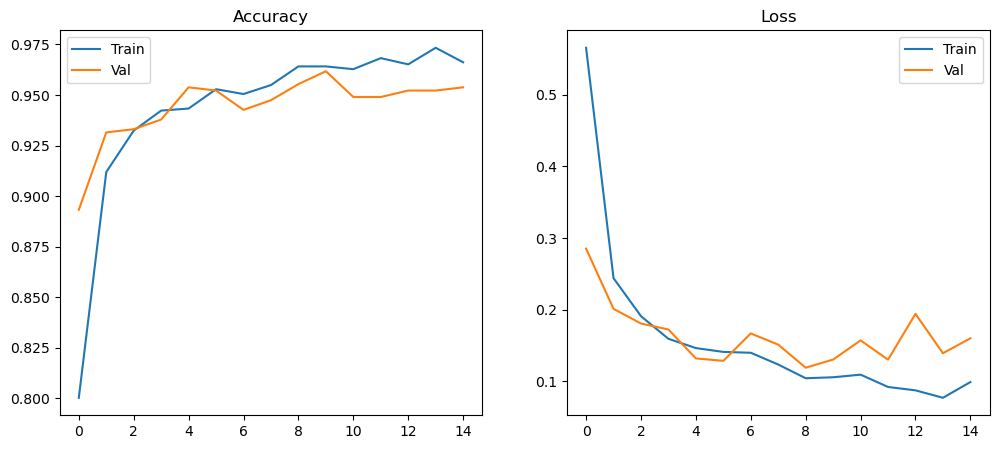

Accuracy: 0.9617834394904459
Precision: 0.9615298041454293
Recall: 0.9617834394904459
F1: 0.9616359623265256
Specificity: 0.948030374940674
MSE: 0.12898089171974522
LogLoss: 0.13010890837045705
AUC: 0.9928625139027667

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       172
           1       0.98      0.99      0.99       196
           2       0.88      0.86      0.87        86
           3       1.00      1.00      1.00       174

    accuracy                           0.96       628
   macro avg       0.95      0.95      0.95       628
weighted avg       0.96      0.96      0.96       628



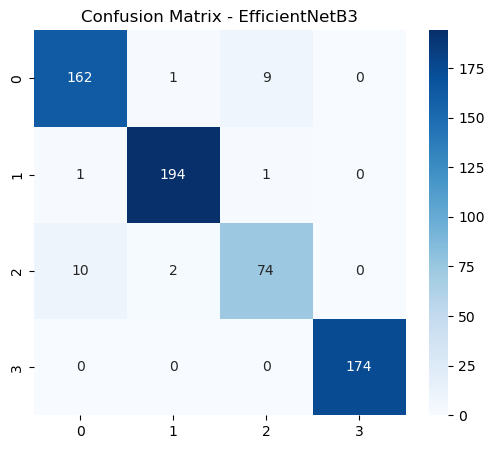

In [1]:
# =========================
# EfficientNet-B3 for Maize Leaf Detection
# =========================
import os, torch, torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, datasets, transforms as T
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_squared_error, log_loss, roc_auc_score,
    classification_report
)
import numpy as np

# ========= Dataset =========
DATA_DIR = r"D:\maize_project\Dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
NUM_CLASSES = len(os.listdir(TRAIN_DIR))
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 15
PATIENCE = 5
SAVE_PATH = "efficientnet_b3_maize.pth"

# ========= Transforms =========
train_tf = T.Compose([
    T.RandomResizedCrop(224), T.RandomHorizontalFlip(),
    T.RandomRotation(20), T.ColorJitter(0.2,0.15,0.15),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize(256), T.CenterCrop(224), T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_tf)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ========= Model =========
model = models.efficientnet_b3(pretrained=True)
in_f = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
scaler = GradScaler()

# ========= Evaluation =========
def evaluate(net, loader):
    net.eval(); correct=total=loss_sum=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            out = net(xb); loss = criterion(out,yb).item()
            _,pred = out.max(1)
            correct+=(pred==yb).sum().item(); total+=yb.size(0)
            loss_sum+=loss*yb.size(0)
    return correct/total, loss_sum/total

# ========= Training =========
train_acc_h, val_acc_h, train_loss_h, val_loss_h = [],[],[],[]
best=0; patience=0

for epoch in range(EPOCHS):
    model.train(); correct=total=0; running_loss=0
    for xb,yb in train_loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            out = model(xb); loss = criterion(out,yb)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running_loss+=loss.item()*yb.size(0)
        _,pred = out.max(1)
        correct+=(pred==yb).sum().item(); total+=yb.size(0)
    train_acc=correct/total; train_loss=running_loss/total
    val_acc,val_loss=evaluate(model,val_loader)
    train_acc_h.append(train_acc); val_acc_h.append(val_acc)
    train_loss_h.append(train_loss); val_loss_h.append(val_loss)
    print(f"[EfficientNet-B3] Epoch {epoch+1}/{EPOCHS} Train={train_acc:.4f} Val={val_acc:.4f}")
    if val_acc>best:
        best=val_acc; patience=0; torch.save(model.state_dict(), SAVE_PATH)
    else:
        patience+=1
        if patience>=PATIENCE: break

print("Best Val Acc:",best)

# ========= Curves =========
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(train_acc_h,label="Train"); plt.plot(val_acc_h,label="Val")
plt.title("Accuracy"); plt.legend()
plt.subplot(1,2,2); plt.plot(train_loss_h,label="Train"); plt.plot(val_loss_h,label="Val")
plt.title("Loss"); plt.legend(); plt.show()

# ========= Final Evaluation =========
model.load_state_dict(torch.load(SAVE_PATH)); model.eval()
y_true,y_pred,y_prob=[],[],[]
with torch.no_grad():
    for xb,yb in val_loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb); probs = torch.softmax(out,dim=1); preds=torch.argmax(probs,1)
        y_true.extend(yb.cpu().numpy()); y_pred.extend(preds.cpu().numpy()); y_prob.extend(probs.cpu().numpy())

y_true=np.array(y_true); y_pred=np.array(y_pred); y_prob=np.array(y_prob)

# Metrics
acc = accuracy_score(y_true,y_pred)
prec=precision_score(y_true,y_pred,average="weighted")
rec =recall_score(y_true,y_pred,average="weighted")
f1  =f1_score(y_true,y_pred,average="weighted")
cm  = confusion_matrix(y_true,y_pred)
spec = np.diag(cm)/(cm.sum(axis=1))   # class-wise specificity
spec = np.nanmean(spec)               # mean specificity
mse = mean_squared_error(y_true,y_pred)
ll  = log_loss(y_true,y_prob)
try: auc = roc_auc_score(y_true,y_prob,multi_class="ovr")
except: auc = None

print("Accuracy:",acc)
print("Precision:",prec)
print("Recall:",rec)
print("F1:",f1)
print("Specificity:",spec)
print("MSE:",mse)
print("LogLoss:",ll)
print("AUC:",auc)
print("\nClassification Report:\n",classification_report(y_true,y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - EfficientNetB3")
plt.show()
